In [1]:
import logging
import torch
import torch.nn as nn
from torchvision import datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import confusion_matrix, roc_curve,auc, roc_auc_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F
from torchvision import transforms as T
import matplotlib.pyplot as plt
import pandas as pd
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class SVHNDataset:
    def __init__(self, root, mean, std,
                 train=True, max_rotation=30, min_crop=0.1, # rotation:10 20 30; min: 0.2,0.4,0.6; max:0.1,0.2,0.3
                 max_aspect_ratio_change=0.2, 
               # brightness_limit=0.2, contrast_limit=0.2
                ):
        self.dataset = datasets.SVHN(root=root, split='train' if train else 'test', download=True)

        self.transform = A.Compose([
            A.Rotate(limit=max_rotation),
            A.RandomResizedCrop(height=32, width=32, scale=(min_crop, 1.0),
                                 ratio=(1-max_aspect_ratio_change, 1+max_aspect_ratio_change)),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ]) if train else A.Compose([
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        img = np.array(img)  
        img = self.transform(image=img)['image']
        return img, target

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


cuda


In [2]:
class EarlyStopping:
    def __init__(self, patience=4, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, test_loss):
        if self.best_loss is None:
            self.best_loss = test_loss
        elif test_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print("Counter+1, the value of counter now is:", self.counter)
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = test_loss
            if self.counter > 0:
                self.counter -= 1

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        out = self.conv_layers(x)
        out += self.shortcut(x)  # Add shortcut connection
        out = nn.ReLU()(out)  # Apply ReLU activation
        return out

class SmallVGG1(nn.Module):
    def __init__(self):
        super(SmallVGG1, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出尺寸: 16*16

            ResidualBlock(16, 32), # 使用残差块
            ResidualBlock(32, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出尺寸: 8*8

            ResidualBlock(32, 32),  # 使用残差块
            nn.MaxPool2d(kernel_size=2, stride=2)   # 输出尺寸: 4*4
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(32*4*4, 256),  # 输入: 32*4*4
            nn.ReLU(),
            nn.Linear(256, 10)  # 输出层（10个类别）
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)
        return x

In [3]:
class SmallVGG(nn.Module):
    def __init__(self):
        super(SmallVGG, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32*4*4, 256),
            nn.ReLU(),
            nn.Linear(256, 10)  
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)
        return x

In [4]:
def plot_class_performance(y_true, y_pred, num_classes):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    classes = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'

    metrics = {
        'Class': classes,
        'Precision': [report[class_name]['precision'] for class_name in classes],
        'Recall': [report[class_name]['recall'] for class_name in classes],
        'F1-Score': [report[class_name]['f1-score'] for class_name in classes],
    }

    df = pd.DataFrame(metrics)
    df.set_index('Class', inplace=True)

    df.plot(kind='bar', figsize=(10, 5))
    plt.title('Class-wise Performance')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid()
    plt.show()

    return df

def summary_table(results):
    df = pd.DataFrame(results)
    print(df)

In [20]:
from tqdm import tqdm
def train(model, train_loader, test_loader, scheduler, criterion, optimizer, device, num_epochs=10):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        with tqdm(train_loader) as pbar: ####
            for i, (images, labels) in enumerate(pbar):
                images, labels = images.to(device), labels.to(device)
    
                optimizer.zero_grad()  # 清空之前的梯度
                outputs = model(images)  # 前向传播
                loss = criterion(outputs, labels)  # 计算损失
                loss.backward()  # 反向传播
                optimizer.step()  # 更新权重
    
                running_loss += loss.item()
    
                # 计算准确率
                _, predicted = torch.max(outputs.data, 1)  # 获取预测的类别
                total += labels.size(0)  # 总样本数
                correct += (predicted == labels).sum().item()  # 正确预测的数量
                pbar.set_postfix(lr=optimizer.param_groups[0]['lr'])
            
        # 每个epoch的平均训练损失和准确率
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # 在测试集上进行评估
        model.eval()
        test_running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_probs = []
        all_preds = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()
                
                preds = torch.argmax(outputs, dim=1)
                # 计算测试准确率
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Store labels and probabilities for ROC calculation
                all_labels.extend(labels.cpu().numpy())  # Use extend for flattening
                all_probs.append(torch.softmax(outputs, dim=1).cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
    
        # 每个epoch的平均测试损失和准确率
        test_loss = test_running_loss / len(test_loader)
        test_accuracy = correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # 打印损失和准确率
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
        early_stopping(test_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        scheduler.step(test_running_loss)

    # Optional: Class performance plotting
    performance_df = plot_class_performance(all_labels, all_preds, 10)

    # Summary table of results
    results_summary = {
        'Metric': ['Accuracy', 'Macro Avg F1'],
        'Value': [test_accuracy, performance_df['F1-Score'].mean()]
    }
    summary_table(results_summary)
    
    all_probs = np.concatenate(all_probs) 
    
    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    # 绘制混淆矩阵
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate ROC AUC
    all_labels = np.array(all_labels)  # Ensure all_labels is an array
    n_classes = all_probs.shape[1]

    # Plot ROC curves for each class
    plt.figure(figsize=(5, 4))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (class {i}) (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Binarize the labels for multi-class
    n_classes = len(np.unique(all_labels))
    all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))

    # Compute the micro ROC curve
    fpr, tpr, _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
    roc_auc = auc(fpr, tpr)

    # Plot the micro ROC curve
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='blue', label=f'Micro ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Macro and Micro AUC calculations
    macro_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
    micro_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='micro')

    print(f'Macro AUC: {macro_auc:.4f}')
    print(f'Micro AUC: {micro_auc:.4f}')
    
    # 绘制训练和测试损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(test_losses, label='Test Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()    
    
    # 绘制训练和测试准确率曲线
    plt.figure(figsize=(12, 6))
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(test_accuracies, label='Test Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy Curves')
    plt.legend()
    plt.grid()
    plt.show()

In [21]:
# rotation:10 30 50; min: 0.2,0.4,0.6; max:0.1,0.3,0.5
# mean = [1., 1., 1.] # 0, 0.5, 1
# std = [0.1, 0.1, 0.1] # 0.1, 0.5, 1
mean=[0.4377, 0.4438, 0.4728]
std=[0.1980, 0.2010, 0.1970]
train_dataset = SVHNDataset(root='./data', train=True, max_rotation=10, min_crop=0.4, max_aspect_ratio_change=0.1, 
                            mean=mean,std=std)
test_dataset = SVHNDataset(root='./data', train=False, 
                           mean=mean, std=std) 

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = SmallVGG().to(device)   # SVHN has 10 classes
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# optimizer = optim.AdamW(model.parameters(), lr=0.0005)
# optimizer = optim.SGD(model.parameters(), lr=0.1) ## 如果不调学习率，网络将会把所有样本归为标签1，经过我们分析得出的结论是网络遭遇了梯度消失
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.02)
# optimizer = optim.Adagrad(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=1) 
early_stopping = EarlyStopping(patience=4, min_delta=0.01)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


100%|██████████| 1145/1145 [00:28<00:00, 39.66it/s, lr=0.0005]


Epoch [1/40], Train Loss: 1.5448, Train Accuracy: 0.4698, Test Loss: 0.7467, Test Accuracy: 0.7664


100%|██████████| 1145/1145 [00:28<00:00, 39.63it/s, lr=0.0005]


Epoch [2/40], Train Loss: 0.7636, Train Accuracy: 0.7584, Test Loss: 0.5465, Test Accuracy: 0.8316


100%|██████████| 1145/1145 [00:28<00:00, 39.57it/s, lr=0.0005]


Epoch [3/40], Train Loss: 0.6083, Train Accuracy: 0.8096, Test Loss: 0.4148, Test Accuracy: 0.8779


100%|██████████| 1145/1145 [00:28<00:00, 39.68it/s, lr=0.0005]


Epoch [4/40], Train Loss: 0.5256, Train Accuracy: 0.8373, Test Loss: 0.4164, Test Accuracy: 0.8766
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:29<00:00, 39.32it/s, lr=0.0005]


Epoch [5/40], Train Loss: 0.4816, Train Accuracy: 0.8515, Test Loss: 0.3612, Test Accuracy: 0.8930


100%|██████████| 1145/1145 [00:29<00:00, 39.41it/s, lr=0.0005]


Epoch [6/40], Train Loss: 0.4428, Train Accuracy: 0.8628, Test Loss: 0.3720, Test Accuracy: 0.8878
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:28<00:00, 39.79it/s, lr=0.0005]


Epoch [7/40], Train Loss: 0.4190, Train Accuracy: 0.8728, Test Loss: 0.3108, Test Accuracy: 0.9100


100%|██████████| 1145/1145 [00:28<00:00, 40.02it/s, lr=0.0005]


Epoch [8/40], Train Loss: 0.3997, Train Accuracy: 0.8773, Test Loss: 0.3140, Test Accuracy: 0.9090
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:28<00:00, 40.04it/s, lr=0.0005]


Epoch [9/40], Train Loss: 0.3833, Train Accuracy: 0.8837, Test Loss: 0.3029, Test Accuracy: 0.9113
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:28<00:00, 40.23it/s, lr=0.0005]


Epoch [10/40], Train Loss: 0.3700, Train Accuracy: 0.8868, Test Loss: 0.3072, Test Accuracy: 0.9094
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:28<00:00, 39.54it/s, lr=0.0005]


Epoch [11/40], Train Loss: 0.3596, Train Accuracy: 0.8902, Test Loss: 0.2839, Test Accuracy: 0.9200


100%|██████████| 1145/1145 [00:29<00:00, 39.40it/s, lr=0.0005]


Epoch [12/40], Train Loss: 0.3461, Train Accuracy: 0.8946, Test Loss: 0.2873, Test Accuracy: 0.9169
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:28<00:00, 39.76it/s, lr=0.0005]


Epoch [13/40], Train Loss: 0.3437, Train Accuracy: 0.8969, Test Loss: 0.2850, Test Accuracy: 0.9196
Counter+1, the value of counter now is: 4
Early stopping


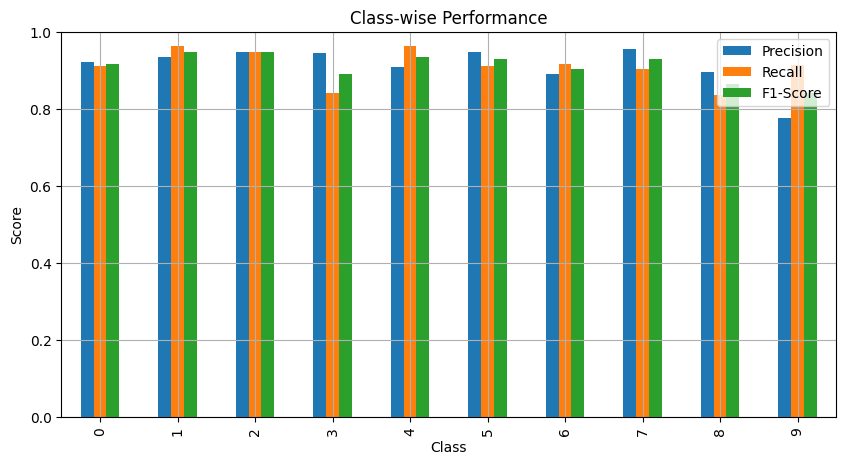

         Metric     Value
0      Accuracy  0.919637
1  Macro Avg F1  0.910322


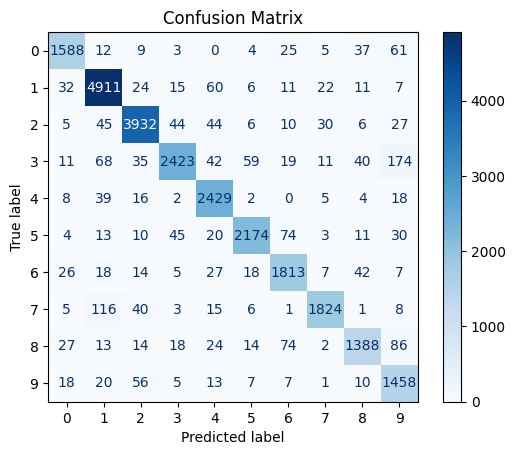

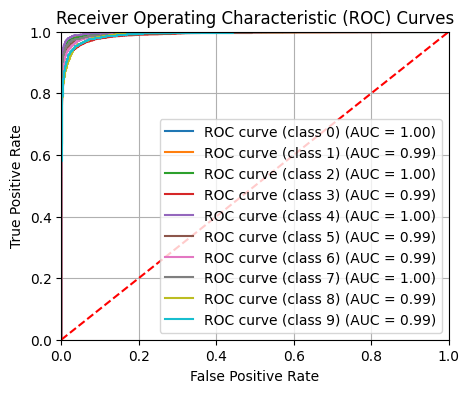

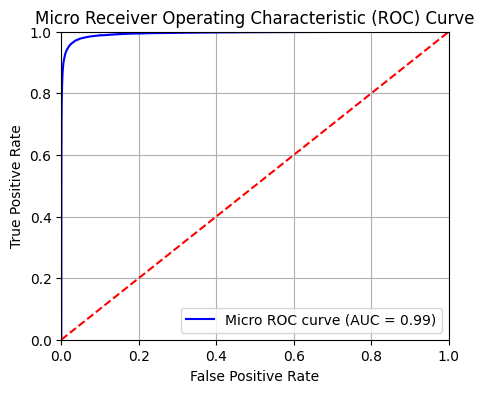

Macro AUC: 0.9939
Micro AUC: 0.9941


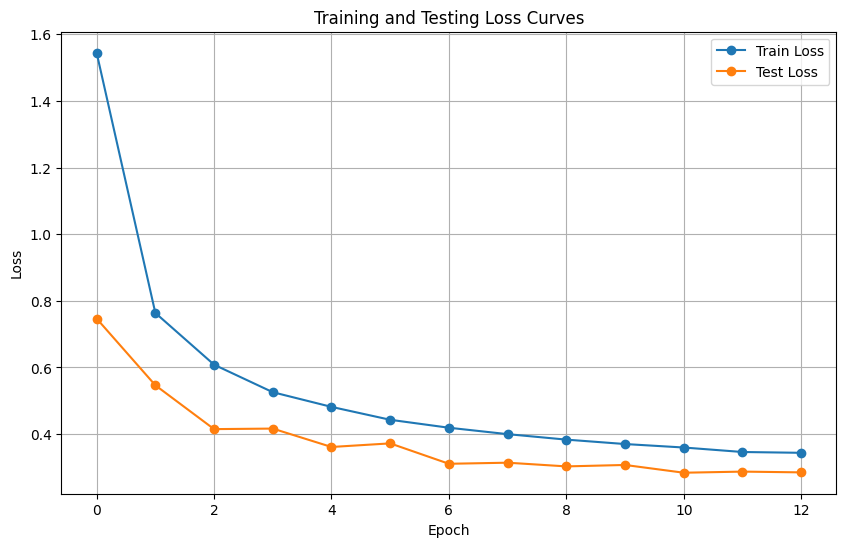

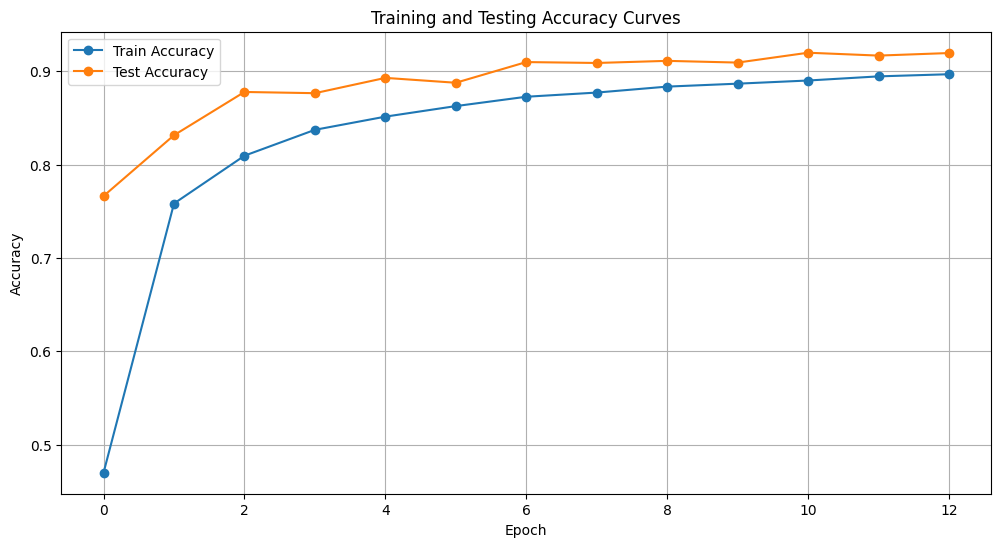

In [22]:
train(model, train_loader, test_loader, scheduler, criterion, optimizer, device, num_epochs=40)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Define the evaluation function
def evaluate(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Compute accuracy
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            # Store labels and probabilities for ROC calculation
            all_labels.extend(labels.cpu().numpy())  # Use extend for flattening
            all_probs.append(torch.softmax(outputs, dim=1).cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

    # Flatten the probabilities list
    all_probs = np.concatenate(all_probs)  # Concatenate to flatten

    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)

    # 绘制混淆矩阵
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate ROC AUC
    all_labels = np.array(all_labels)  # Ensure all_labels is an array
    n_classes = all_probs.shape[1]

    # Plot ROC curves for each class
    plt.figure(figsize=(5, 4))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (class {i}) (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Binarize the labels for multi-class
    n_classes = len(np.unique(all_labels))
    all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))

    # Compute the micro ROC curve
    fpr, tpr, _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
    roc_auc = auc(fpr, tpr)

    # Plot the micro ROC curve
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='blue', label=f'Micro ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Macro and Micro AUC calculations
    macro_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
    micro_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='micro')

    print(f'Macro AUC: {macro_auc:.4f}')
    print(f'Micro AUC: {micro_auc:.4f}')

    # Optional: Class performance plotting
    performance_df = plot_class_performance(all_labels, all_preds, 10)

    # Summary table of results
    results_summary = {
        'Metric': ['Accuracy', 'Macro Avg F1'],
        'Value': [accuracy, performance_df['F1-Score'].mean()]
    }
    summary_table(results_summary)

Epoch [1/40], Train Loss: 0.3009, Train Accuracy: 0.9104, Test Loss: 0.2609, Test Accuracy: 0.9249
Early stopping


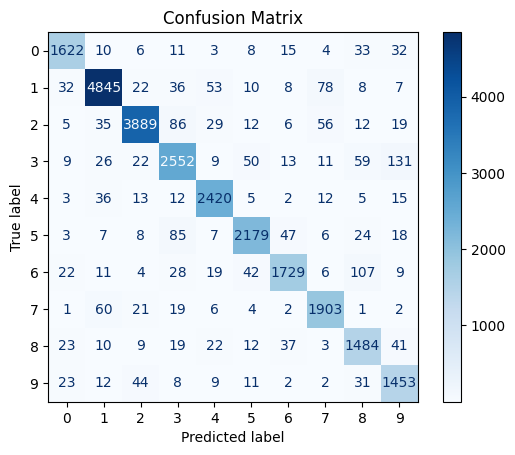

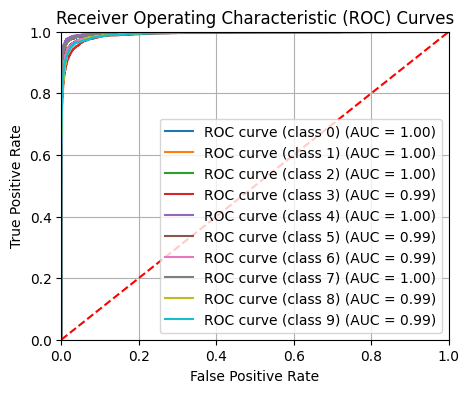

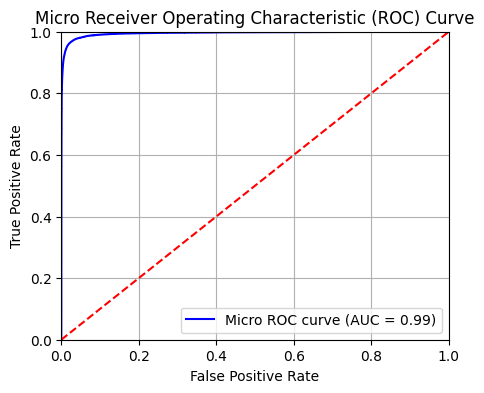

Macro AUC: 0.9945
Micro AUC: 0.9948


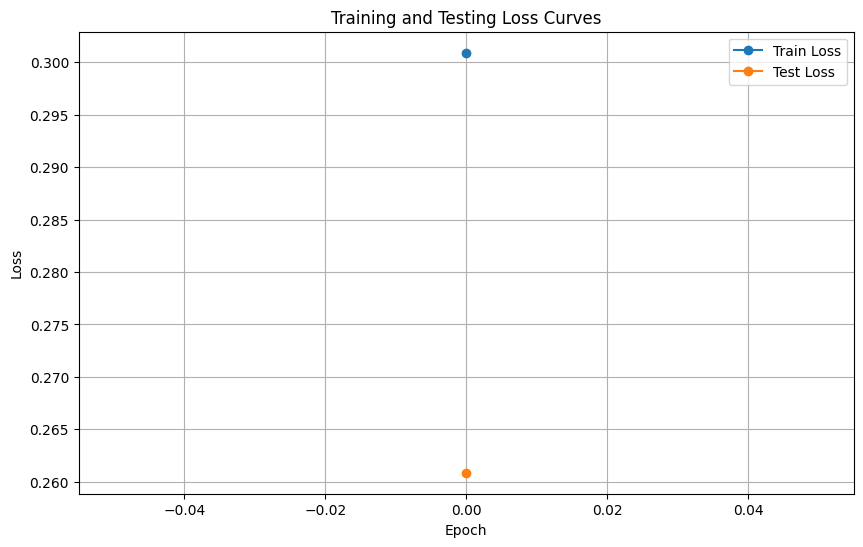

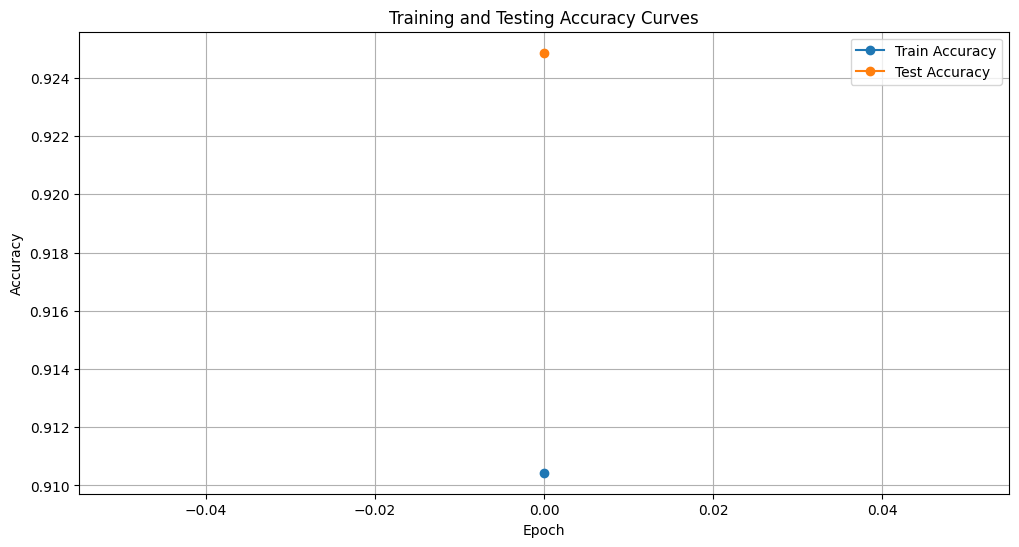

In [20]:
train(model, train_loader, test_loader, criterion,optimizer,device,num_epochs=40)

In [ ]:
# Evaluate the model
# evaluate(model,device,test_loader)

In [5]:
dict = {'g1': 16, 'l1': 288, 'p1': 0.005056366810335579, 'lr': 0.0006316572044621154, 'weight_decay': 8.902160089661776e-05, 'factor': 0.5148745952344611}

mean=[0.4377, 0.4438, 0.4728]
std=[0.1980, 0.2010, 0.1970]
train_dataset = SVHNDataset(root='./data', train=True, max_rotation=10, min_crop=0.4, max_aspect_ratio_change=0.1,
                            mean=mean, std=std)
test_dataset = SVHNDataset(root='./data', train=False, mean=mean, std=std) 
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 182040794/182040794 [00:38<00:00, 4738815.12it/s]


100%|██████████| 64275384/64275384 [00:06<00:00, 9467542.59it/s] 


In [6]:
class SmallVGG(nn.Module):
    def __init__(self, g1, l1, p1=0):
        super(SmallVGG, self).__init__()
        self.conv_layers = nn.Sequential( # 32*32的图像尺寸
            nn.Conv2d(3, 8, kernel_size=3, padding=1), # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
            nn.GroupNorm(4, 8), nn.ReLU(), 
            nn.Conv2d(8, 16, kernel_size=3, padding=1), # 图片尺寸不变
            nn.GroupNorm(4, 16), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出尺寸: 16*16

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.GroupNorm(8, 32), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.GroupNorm(8, 32), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出尺寸: 8*8

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.GroupNorm(8, 32), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.GroupNorm(8, 32), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),   # 输出尺寸: 4*4
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(32*4*4, l1),  # 输入: 32*4*4
            nn.GroupNorm(g1, l1), nn.ReLU(),
            nn.Dropout(p1),
            nn.Linear(l1, 10) # 输出层（10个类别）
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # 类似numpy中reshape，第一个维度保持不变，剩下的维度展平成一个维度
        x = self.fc_layers(x)
        return x

In [10]:
g1 = dict['g1']
l1 = dict['l1']
p1 = dict['p1']
lr = dict['lr']
weight_decay = dict['weight_decay']
factor = dict['factor']

model = SmallVGG(g1=g1, l1=l1, p1=p1).to(device) 
early_stopping = EarlyStopping(patience=4, min_delta=0.01)

100%|██████████| 1145/1145 [00:33<00:00, 34.41it/s, lr=0.000632]


Epoch [1/40], Train Loss: 0.9674, Train Accuracy: 0.6870, Test Loss: 0.4608, Test Accuracy: 0.8589


100%|██████████| 1145/1145 [00:31<00:00, 35.89it/s, lr=0.000632]


Epoch [2/40], Train Loss: 0.5555, Train Accuracy: 0.8266, Test Loss: 0.4051, Test Accuracy: 0.8728


100%|██████████| 1145/1145 [00:32<00:00, 35.68it/s, lr=0.000632]


Epoch [3/40], Train Loss: 0.4702, Train Accuracy: 0.8546, Test Loss: 0.3170, Test Accuracy: 0.9054


100%|██████████| 1145/1145 [00:31<00:00, 36.03it/s, lr=0.000632]


Epoch [4/40], Train Loss: 0.4307, Train Accuracy: 0.8667, Test Loss: 0.2954, Test Accuracy: 0.9117


100%|██████████| 1145/1145 [00:31<00:00, 36.13it/s, lr=0.000632]


Epoch [5/40], Train Loss: 0.3991, Train Accuracy: 0.8776, Test Loss: 0.2985, Test Accuracy: 0.9098
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.09it/s, lr=0.000632]


Epoch [6/40], Train Loss: 0.3750, Train Accuracy: 0.8857, Test Loss: 0.2537, Test Accuracy: 0.9244


100%|██████████| 1145/1145 [00:31<00:00, 36.23it/s, lr=0.000632]


Epoch [7/40], Train Loss: 0.3596, Train Accuracy: 0.8904, Test Loss: 0.2451, Test Accuracy: 0.9274
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.41it/s, lr=0.000632]


Epoch [8/40], Train Loss: 0.3464, Train Accuracy: 0.8945, Test Loss: 0.2349, Test Accuracy: 0.9330


100%|██████████| 1145/1145 [00:31<00:00, 36.35it/s, lr=0.000632]


Epoch [9/40], Train Loss: 0.3381, Train Accuracy: 0.8968, Test Loss: 0.2594, Test Accuracy: 0.9228
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.56it/s, lr=0.000632]


Epoch [10/40], Train Loss: 0.3297, Train Accuracy: 0.8996, Test Loss: 0.2421, Test Accuracy: 0.9284
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.51it/s, lr=0.000325]


Epoch [11/40], Train Loss: 0.2914, Train Accuracy: 0.9121, Test Loss: 0.2045, Test Accuracy: 0.9408


100%|██████████| 1145/1145 [00:31<00:00, 36.40it/s, lr=0.000325]


Epoch [12/40], Train Loss: 0.2860, Train Accuracy: 0.9134, Test Loss: 0.1980, Test Accuracy: 0.9427
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.50it/s, lr=0.000325]


Epoch [13/40], Train Loss: 0.2754, Train Accuracy: 0.9178, Test Loss: 0.2076, Test Accuracy: 0.9406
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.49it/s, lr=0.000325]


Epoch [14/40], Train Loss: 0.2764, Train Accuracy: 0.9165, Test Loss: 0.2012, Test Accuracy: 0.9416
Counter+1, the value of counter now is: 4
Early stopping


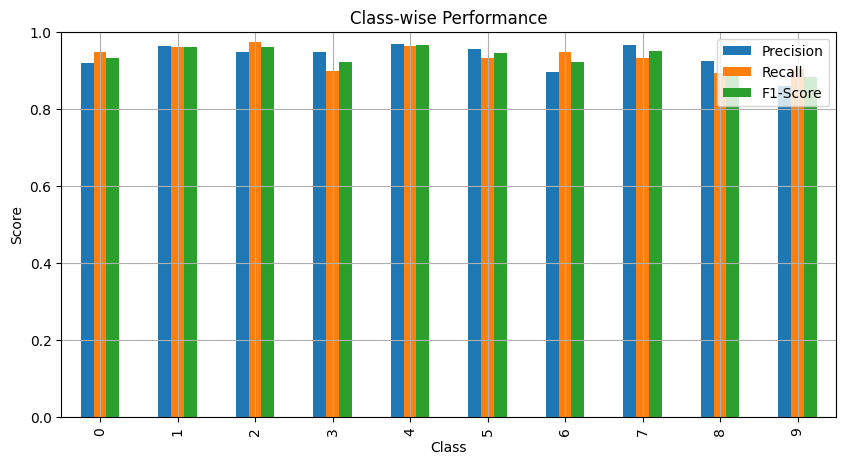

         Metric     Value
0      Accuracy  0.941610
1  Macro Avg F1  0.934776


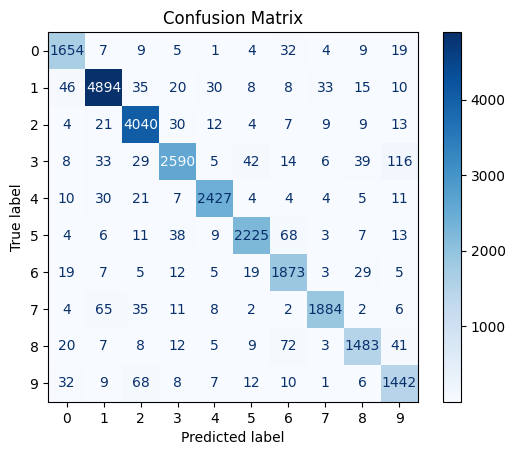

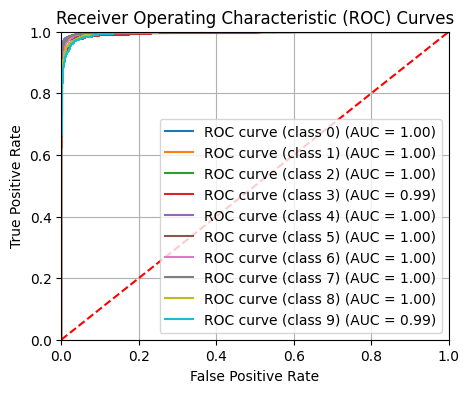

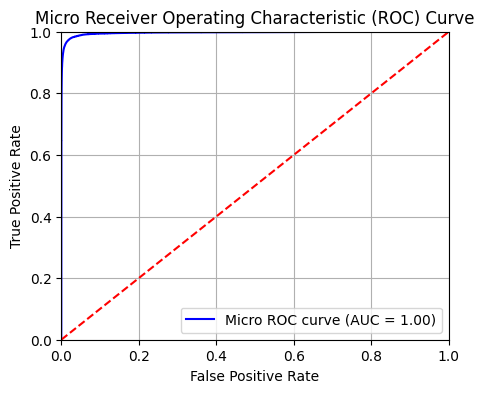

Macro AUC: 0.9963
Micro AUC: 0.9964


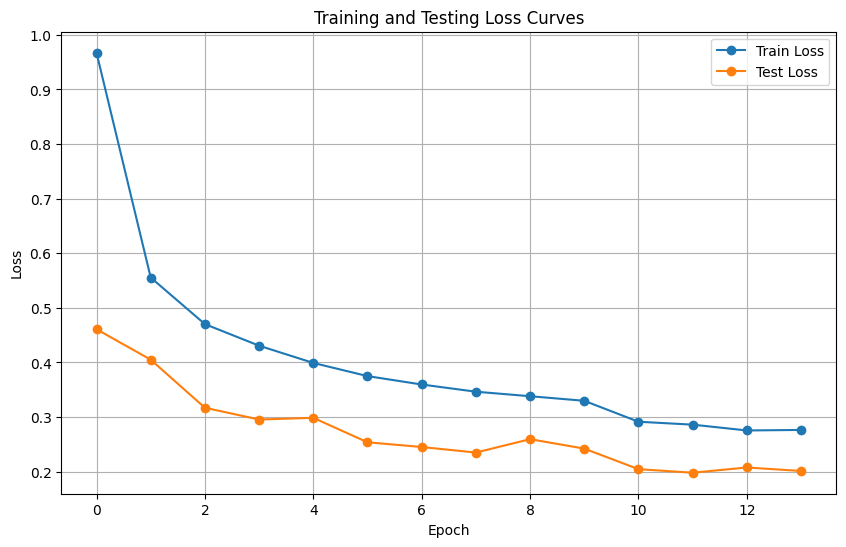

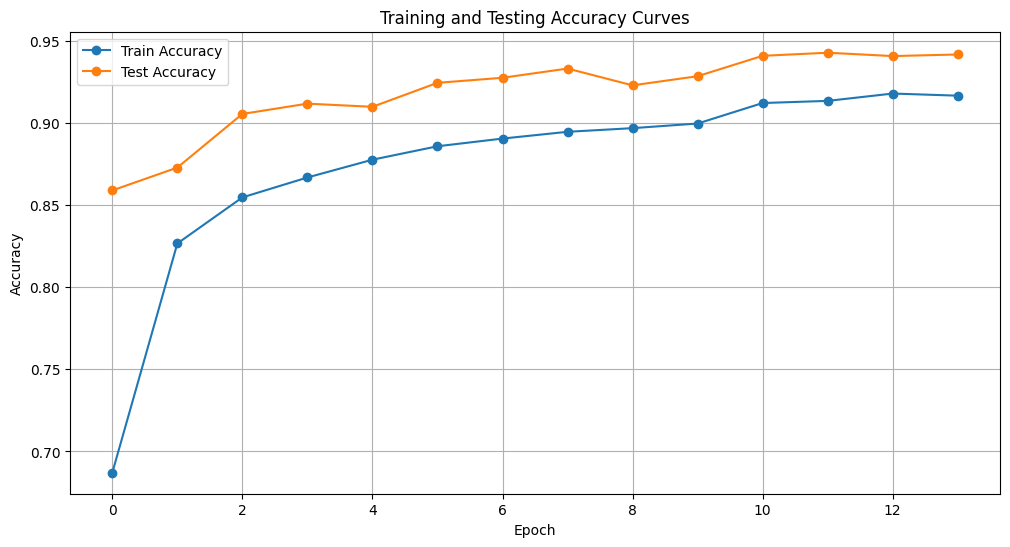

In [12]:
from tqdm import tqdm
def train_eva(model, train_loader, test_loader, criterion, optimizer, scheduler, 
              weight_decay, factor, lr,
              num_epochs=40, device=device):
    model.train()
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        with tqdm(train_loader) as pbar: ####
            for i, (images, labels) in enumerate(pbar):
                images, labels = images.to(device), labels.to(device)
    
                optimizer.zero_grad()  # 清空之前的梯度
                outputs = model(images)  # 前向传播
                loss = criterion(outputs, labels)  # 计算损失
                loss.backward()  # 反向传播
                optimizer.step()  # 更新权重
    
                running_loss += loss.item()
    
                # 计算准确率
                _, predicted = torch.max(outputs.data, 1)  # 获取预测的类别
                total += labels.size(0)  # 总样本数
                correct += (predicted == labels).sum().item()  # 正确预测的数量
                pbar.set_postfix(lr=optimizer.param_groups[0]['lr'])
            
        # 每个epoch的平均训练损失和准确率
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # 在测试集上进行评估
        model.eval()
        test_running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_probs = []
        all_preds = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()
                
                preds = torch.argmax(outputs, dim=1)
                # 计算测试准确率
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Store labels and probabilities for ROC calculation
                all_labels.extend(labels.cpu().numpy())  # Use extend for flattening
                all_probs.append(torch.softmax(outputs, dim=1).cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
    
        # 每个epoch的平均测试损失和准确率
        test_loss = test_running_loss / len(test_loader)
        test_accuracy = correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # 打印损失和准确率
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
        early_stopping(test_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        scheduler.step(test_running_loss)

    # Optional: Class performance plotting
    performance_df = plot_class_performance(all_labels, all_preds, 10)

    # Summary table of results
    results_summary = {
        'Metric': ['Accuracy', 'Macro Avg F1'],
        'Value': [test_accuracy, performance_df['F1-Score'].mean()]
    }
    summary_table(results_summary)
    
    all_probs = np.concatenate(all_probs) 
    
    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    # 绘制混淆矩阵
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate ROC AUC
    all_labels = np.array(all_labels)  # Ensure all_labels is an array
    n_classes = all_probs.shape[1]

    # Plot ROC curves for each class
    plt.figure(figsize=(5, 4))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (class {i}) (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Binarize the labels for multi-class
    n_classes = len(np.unique(all_labels))
    all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))

    # Compute the micro ROC curve
    fpr, tpr, _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
    roc_auc = auc(fpr, tpr)

    # Plot the micro ROC curve
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='blue', label=f'Micro ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Macro and Micro AUC calculations
    macro_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
    micro_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='micro')

    print(f'Macro AUC: {macro_auc:.4f}')
    print(f'Micro AUC: {micro_auc:.4f}')
    
    # 绘制训练和测试损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(test_losses, label='Test Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()    
    
    # 绘制训练和测试准确率曲线
    plt.figure(figsize=(12, 6))
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(test_accuracies, label='Test Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy Curves')
    plt.legend()
    plt.grid()
    plt.show()

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=1)
train_eva(model, train_loader=train_loader, test_loader=test_loader, criterion=nn.CrossEntropyLoss(), 
                                      optimizer=optimizer, scheduler=scheduler,
                                      weight_decay=weight_decay, factor=factor, lr=lr)

In [13]:
# torch.save(model.state_dict(), 'model_params.pth')
dict = {'g1': 16, 'l1': 288, 'p1': 0.005056366810335579, 'lr': 0.0006316572044621154, 'weight_decay': 8.902160089661776e-05, 'factor': 0.5148745952344611}

mean=[0.4377, 0.4438, 0.4728]
std=[0.1980, 0.2010, 0.1970]
train_dataset = SVHNDataset(root='./data', train=True, max_rotation=10, min_crop=0.4, max_aspect_ratio_change=0.1,
                            mean=mean, std=std)
test_dataset = SVHNDataset(root='./data', train=False, mean=mean, std=std) 
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

g1 = dict['g1']
l1 = dict['l1']
p1 = dict['p1']
lr = dict['lr']
weight_decay = dict['weight_decay']
factor = dict['factor']

model = SmallVGG(g1=g1, l1=l1, p1=p1).to(device) 

# 加载参数
model.load_state_dict(torch.load('model_params.pth'))

In [32]:
!pip install gradio==4.41.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 85.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 98.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.9.1 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have googl

In [33]:
import torch
import torch.nn as nn
import numpy as np
import gradio as gr
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import logging
import matplotlib.pyplot as plt

def load_and_display_image(input_image):
    if isinstance(input_image, dict) and 'composite' in input_image:
        image = np.array(input_image['composite'])
    else:
        raise ValueError("Input image is not in the expected format.")

    # Check if the image is grayscale or RGB
    if image.ndim == 2:  # Grayscale image
        plt.imshow(image, cmap='gray')
    elif image.ndim == 3 and image.shape[2] == 3:  # RGB image
        plt.imshow(image)  # No colormap needed for RGB
    else:
        raise ValueError("Input image is not in a recognized format (grayscale or RGB).")

    plt.title('Original Input Image')
    plt.axis('off')
    plt.show()

def preprocess_image(input_image):
    try:
        # Check if the input image is in the expected format
        if isinstance(input_image, dict) and 'composite' in input_image:
            image = np.array(input_image['composite']) ## 首先input_image将会转化成一个三维的np array
            logging.debug(f"Received image shape: {image.shape}")
        else:
            raise ValueError("Input image is not in the expected format.")

        # Convert grayscale to RGB if necessary
        if image.ndim == 2:  # If it's a grayscale image
            image = np.stack((image,) * 3, axis=-1)  # Convert to RGB

        logging.debug(f"Image after conversion to RGB: {image.shape}")

        # Convert to PIL Image
        image = Image.fromarray(image.astype('uint8')).convert("RGB") ## 这个array在这里被转化为一个image object
        logging.debug(f"PIL image size: {image.size}")

        # Transform the image
        transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        tensor = transform(image) ## 对数据进行处理，just like what we do to the test dataset.
        logging.debug(f"Transformed tensor shape: {tensor.shape}")

        tensor = tensor.unsqueeze(0)  # Add batch dimension
        return tensor

    except Exception as e:
        logging.error(f"Error in preprocessing: {e}")
        raise

def predict(input_image):
    try:
        logging.debug("Predict function started.")

        processed_image = preprocess_image(input_image) ## 输入手写预处理
        processed_image = processed_image.to(device)

        with torch.no_grad(): 
            outputs = model(processed_image) ## 将处理过的图像输入模型
            probabilities = F.softmax(outputs, dim=1)[0] ## 将模型输出通过softmax函数进行概率计算，得到每个类别的概率。

            logging.debug(f"Raw outputs: {outputs}")
            logging.debug(f"Probabilities: {probabilities}")

            predictions = {
                str(i): round(float(probabilities[i]), 2) 
                for i in range(10)
            }

            logging.debug(f"Predictions: {predictions}")

            # Return the original image and predictions
            return input_image['composite'], predictions

    except Exception as e:
        logging.error(f"Error in prediction: {e}")
        return {str(i): 0.0 for i in range(10)}

interface = gr.Interface(
    fn=predict,
    inputs=gr.Sketchpad(crop_size=(32, 32), type='numpy', image_mode='L', brush=gr.Brush()), ## 这里先创建了一个画板用于给用户输入手写数字，然后这个数据将会传递给predict函数
    outputs=[ ## 得到output，也就是predict函数返回的值
        gr.Image(type="numpy", label="Input Image"),
        gr.Label(num_top_classes=10)
    ],
    title="Digit Recognition with VGG Network",
    description="Draw a digit (0-9) and the model will predict what digit it is.",
    article="The model will show confidence scores for all digits (0-9).",
    examples=[],
    cache_examples=False,
    theme=gr.themes.Default()
)
if __name__ == "__main__":
    interface.launch(share=True)

/opt/conda/lib/python3.10/site-packages/gradio/analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.41.0, however version 4.44.1 is available, please upgrade. 
--------
  warnings.warn(


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://6b1d41f28e10576b23.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
